<a href="https://colab.research.google.com/github/SanskarGithub07/LLM_Projects/blob/main/2210110898_Sanskar_Sugandhi_LLM_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt) # Tokenizes the entire text

    for i in range(0, len(token_ids) - max_length, stride): # Uses a sliding window to chunk the book into overlapping sequences of max_length
      input_chunk = token_ids[i: i + max_length]
      target_chunk = token_ids[i + 1 : i + max_length + 1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self): # Total number of rows in dataset
    return len(self.input_ids)

  def __getitem__(self, idx): # Returns a single row from the dataset
    return self.input_ids[idx], self.target_ids[idx]

In [2]:
def create_dataloader_v1(txt, batch_size = 4, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0):
  tokenizer = tiktoken.get_encoding("gpt2") # Initializes the tokenizer.
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # Creates dataset
  dataloader = DataLoader(
      dataset,
      batch_size = batch_size,
      shuffle = shuffle,
      drop_last = drop_last, # drop_last = True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training.
      num_workers = num_workers #The number of CPU processes to use for preprocessing
  )

  return dataloader

In [3]:
import torch
from torch import nn
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    assert(d_out % num_heads == 0), \
    "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads # Reduces project dimension to match the output dimension
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # Uses a Linear Layer to combine head outputs
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x) # Tensor shape(b, num_tokens, d_out)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # We implicitly split the matrix by adding a num_heads dimension
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(
        b, num_tokens, self.num_heads, self.head_dim
    )

    keys = keys.transpose(1, 2) # Transposes from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = queries @ keys.transpose(2, 3) # Dot products for each head
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Masks truncated to the number of tokens

    attn_scores.masked_fill_(mask_bool, -torch.inf) # Uses the mask to fill attention scores

    attn_weights = torch.softmax(
        attn_scores / keys.shape[-1] ** 0.5, dim = -1
    )

    context_vec = (attn_weights @ values).transpose(1, 2) # Tensor shape: (b, num_tokens, n_heads, head_dim)
    context_vec = context_vec.contiguous().view( # Combines heads, where self.d_out = self.num_heads * self.head_dim
        b, num_tokens, self.d_out
    )
    context_vec = self.out_proj(context_vec) # Adds an optional linear projection
    return context_vec

In [4]:
import torch
from torch import nn

class GELU(nn.Module):
 def __init__(self):
    super().__init__()

 def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
    torch.sqrt(torch.tensor(2.0 / torch.pi)) *
    (x + 0.044715 * torch.pow(x, 3))
    ))

In [5]:
#Small neural network consisting of two linear layers and a GELU activation function

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

In [6]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

In [7]:
import torch
from torch import nn
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    # Shortcut connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # Add original input back

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # Add original input back
    return x

In [8]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device = in_idx.device) # Allows to train the model on CPU or GPU depending on which device the input data sits on
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [9]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # idx is a (batch, n_tokens) array of indices in the current context.
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:] # Crops the current context if it exceeds the supported context size, e.g., if LLM supports only 5 tokens,  and the context size is 10, then only the last 5 tokens are used as context
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :] # Focuses only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
    probas = torch.softmax(logits, dim = -1) # probas has shape (batch, vocab_size)
    idx_next = torch.argmax(probas, dim = -1, keepdim = True) # idx_next has shape (batch, 1)
    idx = torch.cat((idx, idx_next), dim = 1) # Appends sampled index to the running sequence, where idx has shape (batch, n_tokens + 1)

  return idx

In [10]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0, 1), target_batch.flatten()
  )
  return loss

In [11]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0
  if(len(data_loader) == 0):
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader) # Iteratives over all batches if no fixed num_batches is specified
  else:
    num_batches = min(num_batches, len(data_loader)) # Reduces the number of batches to match the total number of batches in the data loader if num_batches exceeds the number of batches in the data loader

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      total_loss += loss.item() # Sums loss for each batch
    else:
      break
  return total_loss / num_batches # Averages loss over all batches

In [12]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], [] # Initializes lists to track loss and tokens seen
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs): #Starts the main training loop
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad() #Resets loss gradients from the previous batch iteration
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      loss.backward() # Calculates loss gradients
      optimizer.step() # Updates model weights using loss gradients
      tokens_seen += input_batch.numel()
      global_step +=1

      if global_step % eval_freq == 0: #Optional evaluation step
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch + 1} (Step {global_step:06d}): "
        f"Train loss {train_loss:.3f}, "
        f"Val loss {val_loss:.3f}")

    generate_and_print_sample( #Prints a sample text after each epoch
        model, tokenizer, device, start_context
    )
  return train_losses, val_losses, track_tokens_seen

In [13]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval() # Dropout is disabled during evaluation for stable, reproducible results
  with torch.no_grad(): # Disables gradient tracking, which is not required during evaluation to reduce computational overhead
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=eval_iter
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=eval_iter
    )
  model.train()

  return train_loss, val_loss


In [14]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.0 MB/s eta 0:00:00


In [15]:
import tiktoken

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

In [16]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(
        model = model, idx = encoded,
        max_new_tokens = 50, context_size = context_size
    )

  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " ")) # Compact print format
  model.train()

In [17]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 16,
    "n_layers": 16,
    "drop_rate": 0.01,
    "qkv_bias": False
}

torch.manual_seed(146)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.01, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.01, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.01, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featu

In [18]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youench Zerg permanentussiacardschieve theoretical conco ascended Slime


In [19]:
import requests
response1 = requests.get("https://www.gutenberg.org/cache/epub/1342/pg1342.txt")
content1 = response1.text
response2 = requests.get("https://www.gutenberg.org/cache/epub/1400/pg1400.txt")
content2 = response2.text

destination_file = open('concatenated.txt', 'w')
destination_file.write(content1 + content2)
destination_file.close()

In [20]:
file_path = "concatenated.txt"
with open(file_path, 'r', encoding='utf-8') as file:
  text_data = file.read()

In [21]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

Characters:  1762018
Tokens:  480074


In [22]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [23]:
torch.manual_seed(146)
train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [24]:
print("Train Loader:")
for x, y in train_loader:
  print(x.shape, y.shape)

print("\n Validation loader:")
for x, y in val_loader:
  print(x.shape, y.shape)

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)
print("Training Loss: ", train_loss)
print("Validation Loss: ", val_loss)

Training Loss:  11.001629715146827
Validation Loss:  11.005869358143908


In [26]:
torch.manual_seed(146)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), # Returns all the trainable weight parameters of the model
    lr = 0.0005, weight_decay = 0.1
)
num_epochs = 6
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq = 5, eval_iter = 5,
    start_context = "We were to have a superb dinner", tokenizer = tokenizer
)

Ep 1 (Step 000000): Train loss 9.657, Val loss 9.429
Ep 1 (Step 000005): Train loss 8.144, Val loss 7.714
Ep 1 (Step 000010): Train loss 7.226, Val loss 6.749
Ep 1 (Step 000015): Train loss 7.232, Val loss 6.477
Ep 1 (Step 000020): Train loss 7.022, Val loss 6.402
Ep 1 (Step 000025): Train loss 6.720, Val loss 6.327
Ep 1 (Step 000030): Train loss 6.691, Val loss 6.258
Ep 1 (Step 000035): Train loss 6.558, Val loss 6.209
Ep 1 (Step 000040): Train loss 6.454, Val loss 6.116
Ep 1 (Step 000045): Train loss 6.174, Val loss 6.023
Ep 1 (Step 000050): Train loss 6.077, Val loss 5.995
Ep 1 (Step 000055): Train loss 6.191, Val loss 5.971
Ep 1 (Step 000060): Train loss 5.952, Val loss 5.917
Ep 1 (Step 000065): Train loss 6.312, Val loss 5.877
Ep 1 (Step 000070): Train loss 6.368, Val loss 5.892
Ep 1 (Step 000075): Train loss 5.757, Val loss 5.791
Ep 1 (Step 000080): Train loss 6.322, Val loss 5.744
Ep 1 (Step 000085): Train loss 6.569, Val loss 5.732
Ep 1 (Step 000090): Train loss 6.037, Val loss

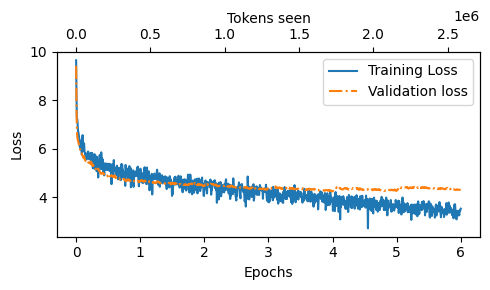

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize = (5, 3))
  ax1.plot(epochs_seen, train_losses, label = "Training Loss")
  ax1.plot(
      epochs_seen, val_losses, linestyle = "-.", label = "Validation loss"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc = "upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer = True))
  ax2 = ax1.twiny() # Creates a second x-axis that shares the same y axis
  ax2.plot(tokens_seen, train_losses, alpha = 0) # Invisible plot for aligning ticks
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [28]:
torch.save(model.state_dict(), 'model.pth')

In [39]:
model_path = "model.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [40]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id =None):
  for i in range(max_new_tokens): # Gets logits and only focuses on the last time step.
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    if top_k is not None: # Filters logits with top_k sampling
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1]
      logits = torch.where(
          logits < min_val,
          torch.tensor(float('-inf')).to(logits.device),
          logits
      )
    if temperature > 0.0: # Applies temperature scaling
      logits = logits / temperature
      probs = torch.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probs, num_samples = 1)
    else: # Carries out greedy next token selection as before when temperature scaling is disabled
      idx_next = torch.argmax(logits, dim = -1, keepdim = True)
    if idx_next == eos_id: # Stops generating early is end-of sequence token is encountered
      break
    idx = torch.cat((idx, idx_next), dim = 1)

  return idx

In [41]:
torch.manual_seed(123)
token_ids = generate(
    model = model,
    idx = text_to_token_ids("We were to have a superb dinner", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"] ,
    top_k = 25,
    temperature = 1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 We were to have a superb dinner window and a
perent. In it was no
a young gentleman
